In [83]:
# 'This is utils.py. I am writing this because I would need to restart the kernel everytime I make changes in utils.py. As for now, it is here. But then we will shift the code to utis.py'
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np



def get_image_shape_stats(images, labels):
    """Get minimum and maximum image shapes for real and fake images"""
    
    # Separate real and fake images based on labels
    real_images = [img for img, label in zip(images, labels) if label == 1]
    fake_images = [img for img, label in zip(images, labels) if label == 0]
    
    # Get the shapes of the real and fake images
    real_shapes = [img.shape for img in real_images]
    fake_shapes = [img.shape for img in fake_images]
    # print(real_shapes, fake_shapes)
    # # Get the minimum and maximum shapes for real and fake images
    min_real_shape = np.min(real_shapes, axis=0)
    max_real_shape = np.max(real_shapes, axis=0)
    
    min_fake_shape = np.min(fake_shapes, axis=0)
    max_fake_shape = np.max(fake_shapes, axis=0)
    
    return min_real_shape, max_real_shape, min_fake_shape, max_fake_shape


def plot_confusion_matrix(all_labels, all_preds):
    # Compute confusion matrix using sklearn's confusion_matrix function
    cm = confusion_matrix(all_labels, all_preds)

    # Plot the confusion matrix using seaborn's heatmap for better visualization
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

-----------------------------------------------------------------

# Importing all the Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from tqdm import tqdm
import numpy as np
import dlib
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [ ]:
# sys.path.append(os.path.abspath('utils'))
# from utils import utils

In [3]:
torch.cuda.is_available()

True

# `Exploratory Data Analysis`

In [3]:
dataset_path = './dataset/'

In [4]:
real_dir = 'dataset/real'
fake_dir = 'dataset/fake'

num_real_images = len(os.listdir(real_dir))
num_fake_images = len(os.listdir(fake_dir))

print(f"Number of real images: {num_real_images}")
print(f"Number of fake images: {num_fake_images}")


Number of real images: 1081
Number of fake images: 960


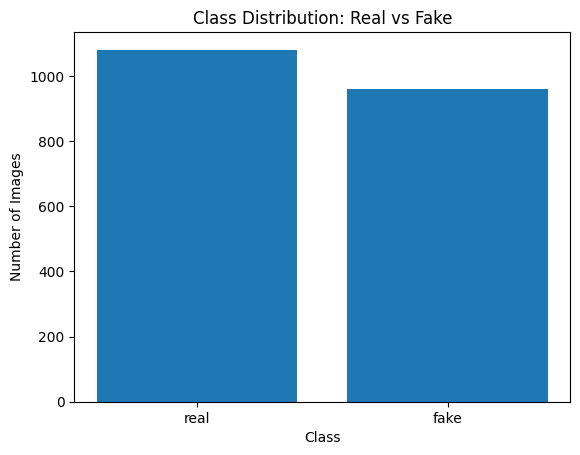

In [5]:
labels = ['real', 'fake']
counts = [num_real_images, num_fake_images]

plt.bar(labels, counts)
plt.title('Class Distribution: Real vs Fake')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [6]:
def load_images(directory):
    """Load images and labels from directory"""
    images = []
    labels = []
    
    # Loop over the two labels with tqdm
    for label in ['real', 'fake']:
        path = os.path.join(directory, label)


        # List all image files and wrap the loop with tqdm
        img_files = os.listdir(path)
        for img_name in tqdm(img_files, desc=f"Loading {label} images", unit="image"):
            
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(1 if label == 'real' else 0)
    
    # Return as numpy arrays
    return np.array(images), np.array(labels)

In [77]:
images, labels = load_images(dataset_path)

Loading fake images: 100%|██████████| 960/960 [00:13<00:00, 71.93image/s]


In [78]:
print("Shape of the Images", images.shape)
print("Shape of the Labels", labels.shape)

Shape of the Images (2041, 600, 600, 3)
Shape of the Labels (2041,)


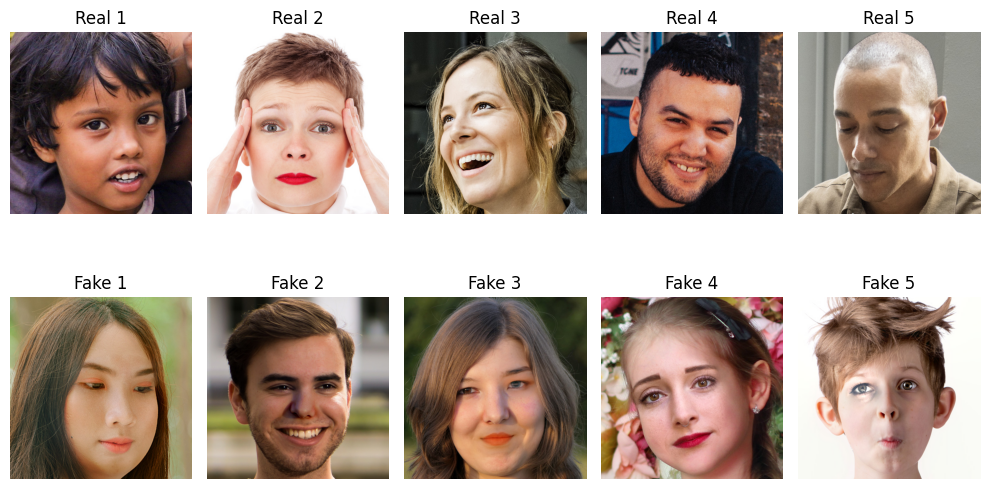

In [79]:
def plot_images(images, labels, num_real=5, num_fake=5):
    # Select 10 real images and 10 fake images
    real_images = [img for img, label in zip(images, labels) if label == 1][:num_real]
    fake_images = [img for img, label in zip(images, labels) if label == 0][:num_fake]
    
    # Create a 5x2 grid (5 rows, 2 columns)
    fig, axes = plt.subplots(2, 5, figsize=(10, 6))
    
    # Plot real images (first 5 rows)
    for i in range(num_real):
        ax = axes[i // 5, i % 5]
        ax.imshow(real_images[i])
        ax.axis('off')
        ax.set_title(f"Real {i+1}")
    
    # Plot fake images (last 5 rows)
    for i in range(num_fake):
        ax = axes[(i + num_real) // 5, (i + num_real) % 5]
        ax.imshow(fake_images[i])
        ax.axis('off')
        ax.set_title(f"Fake {i+1}")
    
    plt.tight_layout()
    plt.show()

plot_images(images, labels)

`Get Minimum and Maximum Shapes of Real and Fake Images`

In [81]:
labels

array([1, 1, 1, ..., 0, 0, 0])

In [85]:
min_real_shape, max_real_shape, min_fake_shape, max_fake_shape = get_image_shape_stats(images, labels)

print("For Real Images - Min: ", min_real_shape, ", Max: ", max_real_shape)
print("For Fake Images - Min: ", min_fake_shape, ", Max: ", max_fake_shape)

For Real Images - Min:  [600 600   3] , Max:  [600 600   3]
For Fake Images - Min:  [600 600   3] , Max:  [600 600   3]


## Running Traditional Machine Learning Models without any sort of Feature Extraction

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import time

In [11]:
from dataset import CustomDatasetLoader

In [12]:
dataset_dir = './dataset/'  # Change to your dataset path
loader = CustomDatasetLoader(dataset_dir, image_size=(128, 128))

images, labels = loader.load_dataset(with_augmentation=False)


Found 1081 real images and 960 fake images
Loading real images...


  0%|          | 0/1081 [00:00<?, ?it/s]

100%|██████████| 1081/1081 [00:14<00:00, 74.85it/s]


Loading fake images...


100%|██████████| 960/960 [00:12<00:00, 76.91it/s]


In [13]:
images.shape, labels.shape

((2041, 128, 128, 3), (2041,))

## `Support Vector Machine`

In [14]:
n_samples = len(images)
flattened_images = images.reshape(n_samples, -1)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(flattened_images)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, labels, test_size=0.2, random_state=42, stratify=labels
    )

In [16]:
start_time = time.time()

param_grid = {
        'C': [ 1],
        'kernel': ['rbf'],
        # 'gamma': ['scale', 'auto', 0.1, 0.01]
    }
    
    # Initialize SVM
svm = SVC(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=3,  # number of folds
    n_jobs=-1,  # use all CPU cores
    scoring='accuracy',
    verbose=2
)
grid_search.fit(X_train, y_train)
    
# Print results
print("\nGrid search completed!")
print(f"Time taken: {(time.time() - start_time) / 60:.2f} minutes")
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
print("\nEvaluating on test set...")
y_pred = grid_search.predict(X_test)

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# Print confusion matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Save best model's predictions
print("\nSaving results...")
try:
    np.save('test_predictions.npy', y_pred)
    np.save('test_true_labels.npy', y_test)
    print("Results saved successfully!")
except Exception as e:
    print(f"Error saving results: {e}")

end_time = time.time()


Fitting 3 folds for each of 1 candidates, totalling 3 fits

Grid search completed!
Time taken: 2.90 minutes

Best parameters: {'C': 1, 'kernel': 'rbf'}
Best cross-validation score: 0.5992647058823529

Evaluating on test set...

Classification Report:
              precision    recall  f1-score   support

        Fake       0.64      0.47      0.54       192
        Real       0.62      0.76      0.68       217

    accuracy                           0.63       409
   macro avg       0.63      0.62      0.61       409
weighted avg       0.63      0.63      0.62       409


Confusion Matrix:
[[ 91 101]
 [ 52 165]]

Saving results...
Results saved successfully!


In [18]:
import joblib

# Save the trained model to a file
model_filename = 'SVM/svm_model.joblib'
joblib.dump(grid_search, model_filename)

print(f"SVM model saved to {model_filename}")


SVM model saved to SVM/svm_model.joblib


## `Random Forest`

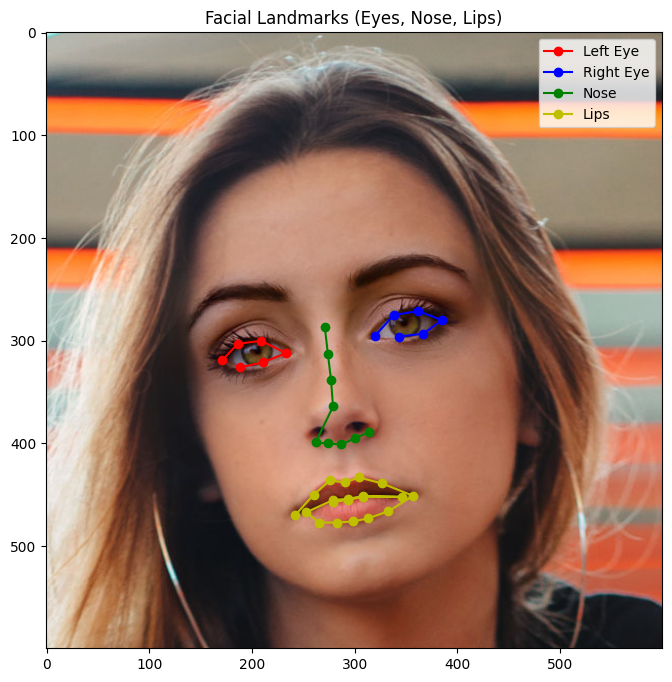

In [ ]:


# Load the image
image_path = "dataset/fake/hard_136_1101.jpg"  # Replace with your image path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for plotting

# Initialize dlib's face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("utils/shape_predictor_68_face_landmarks.dat")  # Path to the model

# Detect faces in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = detector(gray)

# Check if any faces are detected
if len(faces) > 0:
    for face in faces:
        # Get the landmarks
        landmarks = predictor(gray, face)

        # Extract the coordinates for eyes, nose, and lips
        # Eyes (indexes 36 to 41 for the left eye, 42 to 47 for the right eye)
        left_eye = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(36, 42)]
        right_eye = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(42, 48)]

        # Nose (indexes 27 to 35 for the nose region)
        nose = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(27, 36)]

        # Lips (indexes 48 to 67 for the lip region)
        lips = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(48, 68)]

        # Convert lists of coordinates to numpy arrays for easier plotting
        left_eye = np.array(left_eye)
        right_eye = np.array(right_eye)
        nose = np.array(nose)
        lips = np.array(lips)

        # Plotting the facial regions
        plt.figure(figsize=(8, 8))
        plt.imshow(image_rgb)

        # Plot eyes, nose, and lips
        plt.plot(left_eye[:, 0], left_eye[:, 1], 'ro-', label="Left Eye")
        plt.plot(right_eye[:, 0], right_eye[:, 1], 'bo-', label="Right Eye")
        plt.plot(nose[:, 0], nose[:, 1], 'go-', label="Nose")
        plt.plot(lips[:, 0], lips[:, 1], 'yo-', label="Lips")

        # Add labels and title
        plt.title("Facial Landmarks (Eyes, Nose, Lips)")
        plt.legend()
        plt.show()
else:
    print("No faces detected in the image.")
